# Stacking Classifier


Using: http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/



In [1]:
from __future__ import print_function 
from __future__ import division


# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from time import time
from pathlib import Path


import warnings
warnings.filterwarnings('ignore')

# Going to use these base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold, cross_val_score
from mlxtend.classifier import StackingClassifier


from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, make_scorer, fbeta_score, confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


In [2]:
# # What set of hyperparamaters to run?
RUNSHORT='SHORT'
RUNLONG='LONG'
RUNBEST='BEST'
RUNCUSTOM='CUSTOM'
RUNDEFAULT = 'DEFAULT'


# Set this:
whatAreWeRunning = RUNBEST


# What models are we running?
# 
# These are ALL: [('l1',None),('l2',None),('rfc',None),('gbc',None),('decisiontree',None),('kneighbors',None),
#                 ('sgd',None),('bagging',None),('adaboost',None),('gaussiannb',None),
#                  ('baggingBE':'l1'),('adaboostBE':'l2')]
#
# modelList2Run are the classifiers
# stackingModelName is the meta-classifier
# 



#

Other =    [('bagging','l1', RUNCUSTOM), 
           ('bagging','rfc', RUNCUSTOM),
           ('l2', None, RUNCUSTOM),
           ('l1', None, RUNCUSTOM),
           ('rfc', None, RUNCUSTOM),
          ]

base =    [('bagging','l1', RUNCUSTOM), 
           ('bagging','rfc', RUNCUSTOM),
           ('l2', None, RUNCUSTOM),
           ('l1', None, RUNCUSTOM),
           ('rfc', None, RUNCUSTOM),
          ]

Best1 =    [('bagging','l2', RUNCUSTOM), 
           ('bagging','gbc', RUNCUSTOM),
           ('l2', None, RUNCUSTOM),
           ('l1', None, RUNCUSTOM)     
          ]

Best2 =    [('bagging','l2', RUNBEST), 
           ('bagging','gbc', RUNBEST),
           ('l2', None, RUNBEST),
           ('l1', None, RUNBEST)     
          ]


# stacking meta_classifier

Meta1  = ('bagging', 'gbc', RUNBEST)

runs = { 
        1 : (Meta1, Best2)
       }

# Order: (with Defaults)
# use_probas = False,
# average_probas = False,
# use_features_in_secondary = False,
# use_clones = True,
#
stackingParams = {
        1 : (True, True, True, True),
        2 : (True, True, True, True),
        3 : (True, True, True, True),
        4 : (True, True, True, True),
        5 : (True, True, True, True),  
        6 : (True, True, True, True),
        7 : (True, True, True, True),
        8 : (True, True, True, True),
        9 : (True, True, True, True),
        10 : (True, True, True, True)    
       }



# 
#runLogName = 'stacking Short 5p v4'
#logFileName = 'stacking.csv'
runLogName = 'Final 5of5'
logFileName = 'FinalRun.csv'



# Grid search
crossValidationSplits = None   # None = len(modelList2Run)+1
gridSearchVerbose = 4

SMALLDATA = False   # False is the full run of data
SMALLDATASIZE = .95  # use 10% of the dataset


########## Nothing below this to change #########

useStandardScaler = True

# Used to selet the number of features to report for feature importance
FEATURESTOREPORT = 40

goalsToReach = {'AUROC': 0.70,
         'Precision': 0.386,
         'fbeta': 0.44}

# List of base stimator models
modelsList= ['l1', 'l2', 'rfc', 'gbc', 'decisiontree', 'kneighbors', 'sgd', 
             'bagging', 'adaboost', 'gaussiannb']

# Other
beModels = ['bagging','adaboost']

SEED = 42
TESTSIZE = 0.25
FBETA = 0.25

print ('Param setting done')

 

Param setting done


In [3]:
# Load in the train and test datasets
X = pd.read_csv('LendingClub2017_2018FeatureReady.csv.gz',  compression='gzip')
X.head(3)

,loan_amnt,term,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,11575.0,36.0,A,72.0,153000.0,0.0,16.99,0.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7200.0,36.0,E,24.0,50000.0,0.0,6.07,0.0,0.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,7500.0,36.0,A,84.0,110000.0,0.0,13.12,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Prep the data
#Create new dataframe with dummy features
targetVariable = 'loan_status'

# Create separate object for input features
y = X[targetVariable]

# Create separate object for target variable
X.drop(targetVariable, axis = 1, inplace=True)

X.head(3)             

,loan_amnt,term,grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,11575.0,36.0,A,72.0,153000.0,16.99,0.0,0.0,24.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7200.0,36.0,E,24.0,50000.0,6.07,0.0,0.0,72.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,7500.0,36.0,A,84.0,110000.0,13.12,0.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Helper Functions and Classes
CalcScores: Will run the different scores, track them, report, keep a log

In [5]:
def lookupModelName (name):
    modelNames = {'gbc':'gradientboostingclassifier__',
                     'l1':'logisticregression__',
                     'l2':'logisticregression__',
                     'rfc':'randomforestclassifier__',
                     'bagging':'baggingclassifier__',
                     'adaboost':'adaboostclassifier__',
                     'gaussiannb':'gaussiannb__',
                     'gpr' : 'gaussianprocessclassifier_',
                     'decisiontree':'decisiontreeclassifier__',
                     'kneighbors': 'kneighborsclassifier__',
                     'sgd':'sgdclassifier__',
                     'baggingBE':'baggingclassifier__',
                     'adaboostBE':'adaboostclassifier__',
                    }
    return(modelNames[name])
    
    
class calcScores(object):
    def __init__(self, clf, modelName, hyperparameters, hyperparametersBE, X, y, runTime=None, goals=None):

        self.clf = clf
        self.scores = {}
        self.modelName = modelName
        self.hyperparameters = hyperparameters
        self.hyperparametersBE = hyperparametersBE
        self.bestParams = None

        pred = self.clf.predict(X)
        if modelName != 'sgd':
            predProba = self.clf.predict_proba(X)
            rows, cols = predProba.shape
            if cols==2:
                aurocPred = [p[1] for p in predProba]
            else:
                aurocPred = predProba
            fpr, tpr, thresholds = roc_curve(y, aurocPred)
        
        # Test for runtimer
        if runTime:
            runInMinutes = runTime / 60
        else:
            runInMinutes = 0

        if hasattr(clf,'best_score_'):
            bestScore = clf.best_score_
        else:
            bestScore = 0
        if hasattr(clf,'best_params_'):
            self.bestParams = clf.best_params_
        else:
            self.bestParams = hyperparameters
            
        # Track feature importance
        COEF = None
        FI = None
        if hasattr(self.clf,'feature_importances_'):
            FI = self.clf.feature_importances_
        if hasattr(self.clf,'coef_'):
            COEF = self.clf.coef_[0]

     
        self.scores = {'fbeta': fbeta_score(y, pred, beta = FBETA), 
                       'CM': confusion_matrix(y, pred), 
                       'Recall': recall_score(y, pred),
                       'Precision': precision_score(y, pred),
                       'RunTime': runInMinutes,
                       'F1': f1_score(y, pred),
                       'Accuracy': accuracy_score(y, pred),
                       'MAE': mean_absolute_error(y, pred),
                       'r2': r2_score(y, pred),
                       'Best Score': bestScore,
                       'Best Params': self.bestParams,
                       'FI': FI,
                       'COEF': COEF} 

        if modelName == 'sgd':
            self.scores['rocauc_score'] = 0.0
            self.scores['AUROC'] = 0.0
            self.scores['roc_curve'] = (0.,0.,0.)
        else:
            self.scores['rocauc_score'] = roc_auc_score(y, aurocPred)
            self.scores['AUROC'] = auc(fpr, tpr)
            self.scores['roc_curve'] = (fpr, tpr, thresholds)
        
        
        # Test for Goals
        listGoals = ''
        self.scores['Goals'] = 'Not Reached'
        if goalsToReach is not None:
            for goal in goalsToReach:
                if goal in self.scores:
                    if self.scores[goal] is not None:
                        val = goalsToReach[goal]
                        if self.scores[goal] > val:
                            listGoals += '{} of {:5.3f} beats {:5.3f},  '.format(goal,self.scores[goal], val)
                if listGoals:
                    self.scores['Goals'] = listGoals
                    
        # Build table for comparison reporting
        df = pd.DataFrame({'goals': goals , 
                           'target': y, 
                           'predict': pred })
        self.targetResults = df.groupby(['target', 'goals'])['goals'].count().unstack('target').fillna(0)
        self.predictResults = df.groupby(['predict', 'goals'])['goals'].count().unstack('predict').fillna(0)

        
    def plotResults(self):
        display(self.targetResults)
        display(self.predictResults)
        
        
    def printScores(self):      
        print ('Scores:\n\n    Auroc={:5.3f}  rocauc={:5.3f}  fbeta={:5.3f}  recall={:5.3f}  precision={:5.3f}  Run Time(M)={:5.3f}\n'.format(
                    self.scores['AUROC'], self.scores['rocauc_score'], self.scores['fbeta'], 
               self.scores['Recall'], self.scores['Precision'], self.scores['RunTime'] ))  
        print ('    Best Score={:5.3f}'.format(self.scores['Best Score']))
        print ('    Best Params={}'.format(self.scores['Best Params']))
        print ('    Goals= {}'.format(self.scores['Goals']))
        
        
    def getScore(self, scoreName=None):
        if scoreName:
            if scoreName in self.scores:
                return self.scores[scoreName]
            else:
                return None
        else:
            return self.scores['CM']
        
    def plotConfusionMatrix(self):
        print ()
        cmap=plt.cm.Blues
        confusionMatrixLabels = [(0,'Paid'), (1, 'Default')]
        classes = []
        for val, desc in confusionMatrixLabels:
            classes.append('{}({})'.format(desc,val))

        cm = self.scores['CM']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
        
    def plotroc(self):
        print ()
        fpr, tpr, thresholds = self.scores['roc_curve']
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % self.scores['AUROC'])
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    def showAll(self):
        self.printScores()
        self.plotConfusionMatrix()
        self.plotroc()
        self.plotResults()
        self.showFeatureImportances()

    def showFeatureImportances(self):
        if self.scores['FI'] is not None:
            print ('Features Importance for ',self.modelName)
            (pd.Series(self.scores['FI'], index=dataColumns).nlargest(FEATURESTOREPORT).plot(kind='barh', figsize=(15,10)))
            plt.show()
        elif self.scores['COEF'] is not None:
            # The estimated coefficients will all be around 1:
            print('No Feature Importance Using Estimated coefficients')
            (pd.Series(self.scores['COEF'], index=dataColumns).nlargest(FEATURESTOREPORT).plot(kind='barh', figsize=(15,10)))
            plt.show()
        else:
            print ('No features to report for ',self.modelName)
        return
          
        
        
    def logScores(self, runLogName='Test Run', outputFileName='TestRun.csv', verbose=True):
        if verbose:
            print ('\nLogging Results: ' + self.modelName)
       
        results = []
              
    
        hyperparametersToReport = ['loss','max_depth','learning_rate','C','max_iter',
                                   'solver','max_features','n_estimators','max_samples',
                                   'algorithm','penalty','tol', 'var_smoothing',
                                   'min_samples_split','min_samples_leaf','subsample',
                                   'validation_fraction','n_iter_no_change',
                                   'criterion','splitter']
 
        scoresToReport = ['AUROC','fbeta', 'Recall', 'Precision','RunTime', 'F1', 
                          'Accuracy', 'MAE', 'r2']
    
        header = 'Model, Run'
        for report in scoresToReport:
            header += ', {}'.format(report)
            
        for param in hyperparametersToReport:
            header += ', {}'.format(param)
        header += ', runParams'
        
        if self.hyperparametersBE:
            header += ', BaseEstParams'
        #print ('\n')
        #print (header)
        header+= '\n'
       
        # Check is the file exists and than open for write or append
        myFile = Path(outputFileName)
        if myFile.is_file():
            file = open(outputFileName,'a')
        else:
            file = open(outputFileName,'w')
            file.write(header)
    
    
        model = self.clf
        scores = self.scores
           
        # Create a row for the scores
        row = '{}, {}'.format(self.modelName, runLogName)
        for report in scoresToReport:
            if scores[report] is None:
                row += ', None'
            else:
                row += ', {:5.3f}'.format(scores[report])
        
        # continue on the row with the hyperparametes
        
        #print ('model.best_params_ = ',model.best_params_)
        
        # continue on the row with the hyperparametes
        for param in hyperparametersToReport:
            lookup = lookupModelName(self.modelName.split('+')[0])+param
            if lookup in self.bestParams:
                row += ', {}'.format(self.bestParams[lookup])
            elif param in self.bestParams:
                row += ', {}'.format(self.bestParams[param])
            else:
                row += ','


                
        # Format and print the hyperparamaters
        hp = self.hyperparameters
        hpStr = '{'
        for h in hp:
            hpStr+='{}: {},'.format(h,hp[h])
        hpStr += '}'
        row += ',"{}"'.format(hpStr)
        
        # add the base_estimator HPs
        if self.hyperparametersBE:
            row += ',"{}"'.format(self.hyperparametersBE)
            
        #print (row)
        row += '\n'
        file.write(row)
           
        file.close()
        #print ('\n')
        #for x in model.best_params_ :
        #    print (x)
   

# Parameters for models - Various modes

- Short is to run gridsearch on a select # paramaters
- Long is a complete range of paramaters to help narrow down
- Best has the best paramaters so far

In [6]:
# Put in our parameters for classifiers
# There are short and long version of hyperparameters based upon the run type

############### logisticregression L1 #################
# LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
# intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, 
# multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None)[source]
#
#
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# 
l1_hyperparameters_short = {
                'logisticregression__solver' : ['liblinear'],
                'logisticregression__max_iter': [10, 15, 25], 
                'logisticregression__C' : [.01, .1, 10, 50]
                 }
l1_hyperparameters_long = {
                'logisticregression__solver' : ['liblinear', 'saga'],
                'logisticregression__C' : [.0001,.001, .01, .1, 10, 30, 50 ,100, 250, 500, 1000],
                'logisticregression__max_iter': [15, 25, 50, 100, 300, 500]
                }
l1_hyperparameters_best = {
                'logisticregression__C': [.1], 
                'logisticregression__max_iter': [25], 
                'logisticregression__solver': ['liblinear']
                }

l1_hyperparameters_custom = {
                'logisticregression__C': [10], 
                'logisticregression__max_iter': [15], 
                'logisticregression__solver': ['liblinear']
                }


############### logisticregression L2 #################
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
l2_hyperparameters_short = {
                'logisticregression__solver' : ['lbfgs', 'liblinear','sag'],
                'logisticregression__max_iter': [20, 25, 30], 
                'logisticregression__C' : [.001, .01, .1, 1.0, 10.]
                }
l2_hyperparameters_long = {
                'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'logisticregression__C' : [.0001,.001, .01, .1, 10, 50, 100, 250, 500, 1000],
                'logisticregression__max_iter': [15, 25, 50, 100, 300, 500]
                }
l2_hyperparameters_best = {
                'logisticregression__C': [.1], 
                'logisticregression__max_iter': [25], 
                'logisticregression__solver': ['sag']
                }
l2_hyperparameters_custom = {
                'logisticregression__solver' : ['lbfgs'],
                'logisticregression__max_iter': [20], 
                'logisticregression__C' : [.001]
                }

    
    

############### randomforestclassifier #################
#
# RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, 
#      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#      max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#      min_impurity_split=None, bootstrap=True, oob_score=False, 
#      n_jobs=None, random_state=None, verbose=0, warm_start=False, 
#      class_weight=None)
#
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#
rfc_hyperparameters_short = {
                'randomforestclassifier__n_estimators': [200, 250],
                'randomforestclassifier__max_features': [1.0, .80, 0.33]
                }
rfc_hyperparameters_long = {
                'randomforestclassifier__n_estimators': [10, 50, 100, 200],
                'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33, .11, 1.0]
                }
rfc_hyperparameters_best = {
                'randomforestclassifier__n_estimators': [200],
                'randomforestclassifier__max_features': [1.0]
                }
 
rfc_hyperparameters_custom = {
                'randomforestclassifier__n_estimators': [200],
                'randomforestclassifier__max_features': [1.0]
                }

    
    
############### gradientboostingclassifier #################
#
# GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, 
#      subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1,
#      min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
#      min_impurity_split=None, init=None, random_state=None, max_features=None, 
#      verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, 
#      validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
#
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
#
#
gbc_hyperparameters_short = {
                'gradientboostingclassifier__n_estimators': [300, 500],
                'gradientboostingclassifier__min_samples_split': [500],
                'gradientboostingclassifier__loss': ['deviance'],
                'gradientboostingclassifier__min_samples_leaf': [25],
                'gradientboostingclassifier__max_features': ['sqrt'],
                'gradientboostingclassifier__max_depth': [6, 8],
                'gradientboostingclassifier__learning_rate':[1., .1, .01],
                'gradientboostingclassifier__subsample': [.8],
                'gradientboostingclassifier__validation_fraction' :[0.1],
                'gradientboostingclassifier__n_iter_no_change' :[10],
                'gradientboostingclassifier__tol':[0.001]
                }
gbc_hyperparameters_long = {
                'gradientboostingclassifier__min_samples_split': [2, 100, 500],
                'gradientboostingclassifier__min_samples_leaf': [1, 50],
                'gradientboostingclassifier__max_features': ['sqrt'],
                'gradientboostingclassifier__subsample': [1., .8],
                'gradientboostingclassifier__n_estimators': [175, 225],
                'gradientboostingclassifier__max_depth': [6, 8, 10, 12],
                'gradientboostingclassifier__loss': ['exponential','deviance'],
                'gradientboostingclassifier__learning_rate':[.2, .1, .01, .05],
                'gradientboostingclassifier__validation_fraction' :[0.1],
                'gradientboostingclassifier__n_iter_no_change' :[5,10],
                'gradientboostingclassifier__tol':[.1, .01, 0.001]
                }



gbc_hyperparameters_best = {
                'gradientboostingclassifier__n_estimators': [300],
                'gradientboostingclassifier__min_samples_split': [500],
                'gradientboostingclassifier__loss': ['deviance'],
                'gradientboostingclassifier__min_samples_leaf': [25],
                'gradientboostingclassifier__max_features': ['sqrt'],
                'gradientboostingclassifier__max_depth': [6],
                'gradientboostingclassifier__learning_rate':[.1],
                'gradientboostingclassifier__subsample': [.8],
                'gradientboostingclassifier__validation_fraction' :[0.1],
                'gradientboostingclassifier__n_iter_no_change' :[10],
                'gradientboostingclassifier__tol':[0.001]
                 }

gbc_hyperparameters_custom = {
                'gradientboostingclassifier__n_estimators': [300],
                'gradientboostingclassifier__min_samples_split': [500],
                'gradientboostingclassifier__loss': ['deviance'],
                'gradientboostingclassifier__min_samples_leaf': [25],
                'gradientboostingclassifier__max_features': ['sqrt'],
                'gradientboostingclassifier__max_depth': [6],
                'gradientboostingclassifier__learning_rate':[1.],
                'gradientboostingclassifier__subsample': [.8],
                'gradientboostingclassifier__validation_fraction' :[0.1],
                'gradientboostingclassifier__n_iter_no_change' :[10],
                'gradientboostingclassifier__tol':[0.001]
                }


############### baggingclassifier #################
bagging_hyperparameters_short = {
               'baggingclassifier__max_features': [.75, 1.], 
               'baggingclassifier__max_samples': [.75, 1.], 
               'baggingclassifier__n_estimators': [50, 100]}

bagging_hyperparameters_long = {
                'baggingclassifier__n_estimators':[5, 10, 100], 
                'baggingclassifier__max_samples':[.5, .75, .95, 1.], 
                'baggingclassifier__max_features':[ .50, .75, .95, 1.]
                }
bagging_hyperparameters_best = {
               'baggingclassifier__max_features': [.75], 
               'baggingclassifier__max_samples': [.75], 
               'baggingclassifier__n_estimators': [100]}

bagging_hyperparameters_custom = {
               'baggingclassifier__max_features': [.75], 
               'baggingclassifier__max_samples': [.75], 
               'baggingclassifier__n_estimators': [100]}


############### ADABOOST #################
adaboost_hyperparameters_short = {'adaboostclassifier__n_estimators':[10, 100], 
                'adaboostclassifier__learning_rate':[.9, 1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}

adaboost_hyperparameters_long = {
                'adaboostclassifier__n_estimators':[10, 50, 100], 
                'adaboostclassifier__learning_rate':[.1, 0.5, 1.0], 
                'adaboostclassifier__algorithm':['SAMME', 'SAMME.R']
                }
adaboost_hyperparameters_best = {'adaboostclassifier__n_estimators':[100], 
                'adaboostclassifier__learning_rate':[1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}

adaboost_hyperparameters_custom = {'adaboostclassifier__n_estimators':[100], 
                'adaboostclassifier__learning_rate':[1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}


############### gaussiannb #################
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
#
# GaussianNB(priors=None, var_smoothing=1e-09)
#

gaussiannb_hyperparameters_short = {
                'gaussiannb__var_smoothing':[ 1.0, .01, .001]
                }
gaussiannb_hyperparameters_long = {
                'gaussiannb__var_smoothing':[ 1., 1e-2, 1e-1, 1e-3, 1e-5, 1e-9]
                }
gaussiannb_hyperparameters_best = {
                'gaussiannb__var_smoothing': [1.0]
                }
gaussiannb_hyperparameters_custom = {
                'gaussiannb__var_smoothing': [1.0]
                }


############### gaussiannb #################
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
#
# GaussianNB(priors=None, var_smoothing=1e-09)
#

gpr_hyperparameters_short = {
                'gaussianprocessclassifier__max_iter_predict':[100],
                'gaussianprocessclassifier__n_restarts_optimizer': [0]
                }
gpr_hyperparameters_long = {
                'gaussianprocessclassifier__max_iter_predict':[50, 100, 200],
                'gaussianprocessclassifier__n_restarts_optimizer': [0]
                }
gpr_hyperparameters_best = {
                'gaussianprocessclassifier__max_iter_predict':[100],
                'gaussianprocessclassifier__n_restarts_optimizer': [0]
                }

gpr_hyperparameters_custom = {
                'gaussianprocessclassifier__max_iter_predict':[100],
                'gaussianprocessclassifier__n_restarts_optimizer': [0]
                }
 

############### decisiontree #################
#
#  class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, 
#         max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#         max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#         min_impurity_split=None, class_weight=None, presort=False)
#
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

decisiontree_hyperparameters_short = {'decisiontreeclassifier__splitter': ['best'], 
                                     'decisiontreeclassifier__min_samples_leaf': [100, 150], 
                                     'decisiontreeclassifier__min_samples_split': [100, 150], 
                                     'decisiontreeclassifier__criterion': ['entropy'], 
                                     'decisiontreeclassifier__max_features': [1.0], 
                                     'decisiontreeclassifier__max_depth': [10]}
decisiontree_hyperparameters_long = {
                'decisiontreeclassifier__criterion' :['gini', 'entropy'],
                'decisiontreeclassifier__splitter' :['best', 'random'],
                'decisiontreeclassifier__min_samples_split' :[2, 50, 100],
                'decisiontreeclassifier__min_samples_leaf': [1, 50, 100],
                'decisiontreeclassifier__max_features': ['sqrt','auto','log2',1., .2, .5],
                'decisiontreeclassifier__max_depth':[None, 1, 10, 50, 100, 250]
                }
decisiontree_hyperparameters_best = {'decisiontreeclassifier__splitter': ['best'], 
                                     'decisiontreeclassifier__min_samples_leaf': [100], 
                                     'decisiontreeclassifier__min_samples_split': [100], 
                                     'decisiontreeclassifier__criterion': ['entropy'], 
                                     'decisiontreeclassifier__max_features': [1.0], 
                                     'decisiontreeclassifier__max_depth': [10]}

decisiontree_hyperparameters_custom = {'decisiontreeclassifier__splitter': ['best'], 
                                     'decisiontreeclassifier__min_samples_leaf': [100], 
                                     'decisiontreeclassifier__min_samples_split': [100], 
                                     'decisiontreeclassifier__criterion': ['entropy'], 
                                     'decisiontreeclassifier__max_features': [1.0], 
                                     'decisiontreeclassifier__max_depth': [10]}


############### kneighbors #################
kneighbors_hyperparameters_short = {}
kneighbors_hyperparameters_long = {}
kneighbors_hyperparameters_best = {}
kneighbors_hyperparameters_custom = {}


############### sgdclassifier #################
sgd_hyperparameters_short = {
                'sgdclassifier__loss': ['hinge'], # 
                'sgdclassifier__penalty': ['l2'], # 'none', 'l2', 'l1', or 'elasticnet'
                'sgdclassifier__max_iter': [1000],
                'sgdclassifier__tol': [1e-3 ]
                }
sgd_hyperparameters_long = {
                'sgdclassifier__loss': ['hinge', 'squared_loss', 'perceptron'], # 
                'sgdclassifier__penalty': ['l2', 'elasticnet'], # 'none', 'l2', 'l1', or 'elasticnet'
                'sgdclassifier__max_iter': [10, 100, 1000],
                'sgdclassifier__tol': [1e-1 , 1e-2 , 1e-3 ] 
                }
sgd_hyperparameters_best = {
                'sgdclassifier__loss': ['perceptron'], # 
                'sgdclassifier__penalty': ['elasticnet'], # 'none', 'l2', 'l1', or 'elasticnet'
                'sgdclassifier__max_iter': [100],
                'sgdclassifier__tol': [0.01] 
                }

sgd_hyperparameters_custom = {
                'sgdclassifier__loss': ['perceptron'], # 
                'sgdclassifier__penalty': ['elasticnet'], # 'none', 'l2', 'l1', or 'elasticnet'
                'sgdclassifier__max_iter': [100],
                'sgdclassifier__tol': [0.01] 
                }


############### baggingclassifier #################
baggingBE_hyperparameters_short = {
               'baggingclassifier__max_features': [1., .75], 
               'baggingclassifier__max_samples': [1., .75], 
               'baggingclassifier__n_estimators': [10, 100]}

baggingBE_hyperparameters_long = {
                'baggingclassifier__n_estimators':[5, 10, 100], 
                'baggingclassifier__max_samples':[.5, .75, .95, 1.], 
                'baggingclassifier__max_features':[ .50, .75, .95, 1.]
                }

baggingBE_hyperparameters_best = {
               'baggingclassifier__max_features': [1.], 
               'baggingclassifier__max_samples': [1.], 
               'baggingclassifier__n_estimators': [10]}

baggingBE_hyperparameters_custom = {
               'baggingclassifier__max_features': [.75], 
               'baggingclassifier__max_samples': [.75], 
               'baggingclassifier__n_estimators': [10]}


############### ADABOOST #################
adaboostBE_hyperparameters_short = {'adaboostclassifier__n_estimators':[10, 100], 
                'adaboostclassifier__learning_rate':[.1, .5, 1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}

adaboostBE_hyperparameters_long = {
                'adaboostclassifier__n_estimators':[10, 50, 100], 
                'adaboostclassifier__learning_rate':[.1, 0.5, 1.0], 
                'adaboostclassifier__algorithm':['SAMME', 'SAMME.R']
                }
adaboostBE_hyperparameters_best = {'adaboostclassifier__n_estimators':[100], 
                'adaboostclassifier__learning_rate':[1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}

adaboostBE_hyperparameters_custom = {'adaboostclassifier__n_estimators':[100], 
                'adaboostclassifier__learning_rate':[1.0], 
                'adaboostclassifier__algorithm':['SAMME.R']}


print ('Hyperparameters setting done')


Hyperparameters setting done


In [7]:

hyperparameters_short = {'l1':l1_hyperparameters_short, 'l2':l2_hyperparameters_short, 
                         'rfc':rfc_hyperparameters_short, 'gbc':gbc_hyperparameters_short, 
                         'decisiontree':decisiontree_hyperparameters_short, 
                         'kneighbors':kneighbors_hyperparameters_short, 
                         'sgd':sgd_hyperparameters_long, 
                         'gpr':gpr_hyperparameters_long, 
                         'bagging':bagging_hyperparameters_short, 
                         'adaboost':adaboost_hyperparameters_short,
                         'baggingBE':bagging_hyperparameters_short, 
                         'adaboostBE':adaboost_hyperparameters_short,
                         'gaussiannb': gaussiannb_hyperparameters_short}


hyperparameters_long = {'l1':l1_hyperparameters_long, 'l2':l2_hyperparameters_long, 
                        'rfc':rfc_hyperparameters_long, 'gbc':gbc_hyperparameters_long, 
                        'decisiontree':decisiontree_hyperparameters_long, 
                        'kneighbors':kneighbors_hyperparameters_long, 
                        'sgd':sgd_hyperparameters_long, 
                        'gpr':gpr_hyperparameters_long, 
                        'bagging':bagging_hyperparameters_long, 
                        'adaboost':adaboost_hyperparameters_long,
                        'baggingBE':bagging_hyperparameters_long, 
                        'adaboostBE':adaboost_hyperparameters_long,
                        'gaussiannb': gaussiannb_hyperparameters_long}

hyperparameters_best = {'l1':l1_hyperparameters_best, 'l2':l2_hyperparameters_best, 
                        'rfc':rfc_hyperparameters_best, 'gbc':gbc_hyperparameters_best, 
                        'decisiontree':decisiontree_hyperparameters_best, 
                        'kneighbors':kneighbors_hyperparameters_best, 
                        'sgd':sgd_hyperparameters_best, 
                        'gpr':gpr_hyperparameters_best, 
                        'bagging':bagging_hyperparameters_best, 
                        'adaboost':adaboost_hyperparameters_best,
                        'baggingBE':bagging_hyperparameters_best, 
                        'adaboostBE':adaboost_hyperparameters_best,
                        'gaussiannb': gaussiannb_hyperparameters_best}

hyperparameters_custom = {'l1':l1_hyperparameters_custom, 
                          'l2':l2_hyperparameters_custom, 
                          'rfc':rfc_hyperparameters_custom, 
                          'gbc':gbc_hyperparameters_custom, 
                          'decisiontree':decisiontree_hyperparameters_custom, 
                          'kneighbors':kneighbors_hyperparameters_custom, 
                          'sgd':sgd_hyperparameters_custom, 
                          'gpr':gpr_hyperparameters_custom, 
                          'bagging':bagging_hyperparameters_custom, 
                          'adaboost':adaboost_hyperparameters_custom,
                          'baggingBE':bagging_hyperparameters_custom, 
                          'adaboostBE':adaboost_hyperparameters_custom,
                          'gaussiannb': gaussiannb_hyperparameters_custom}


models = {'l1':LogisticRegression(penalty='l1', random_state=SEED, n_jobs=-2), 
          'l2': LogisticRegression(penalty='l2', random_state=SEED, n_jobs=-2), 
          'rfc': RandomForestClassifier(random_state=SEED, n_jobs=-2), 
          'gbc': GradientBoostingClassifier(random_state=SEED),
          'decisiontree': DecisionTreeClassifier(random_state=SEED),
          'kneighbors': KNeighborsClassifier(n_jobs=-2), 
          'sgd': SGDClassifier(random_state=SEED, n_jobs=-2),
          'bagging': BaggingClassifier(random_state=SEED, n_jobs=-2),
          'adaboost': AdaBoostClassifier(random_state=SEED),
          'gaussiannb': GaussianNB()
          }

def get_feature_importance(self, clf, modelName ):
        clfs = {'rfc':'feature_importances',
                'adaboost': 'feature_importances',
                'l1': 'coef',
                'l2': 'coef',
                'sgd': 'coef',
                'bagging': None, 
                'gbc': 'feature_importances',
                'gpr': None,
                'gaussiannb': None,
                'decisiontree': 'feature_importances',
                'kneighbors': None}

        if clfs[modelName] == 'feature_importances':
            return  list(clf.feature_importances_)
        elif clfs[modelName] == 'coef':
            return  list(clf.coef_.tolist())
        else:
            return None 

print ('Hyperparameters setting done')



Hyperparameters setting done


In [8]:
# Build a model based upon the model type (model with a base_estimator i.e. baggingBE)
# theModel is ('modelname': 'Base estimator Name if there is one')

def fixHyperparameters(params, useList=False):
    cleanParam = {}
    for p in params:
        paramName = p.split('__',1)[1]
        if useList:
            value = params[p]
        else:
            value = params[p][0]
        cleanParam[paramName] = value
    return cleanParam

def buildModel (theModel):
    
    modelName, modelNameBE, whatParams = theModel
    
    if whatParams is not None:
        paramsToRunWith = whatParams
    else:
        paramsToRunWith = whatAreWeRunning

    if modelName in beModels and modelNameBE is not None:
        baseModel = modelName+'BE'
    else:
        baseModel = modelName

    if paramsToRunWith==RUNSHORT:
        params =  hyperparameters_short[baseModel]
    elif paramsToRunWith==RUNLONG:
        params =  hyperparameters_long[baseModel]
    elif paramsToRunWith==RUNBEST:
        params =  hyperparameters_best[baseModel]
    elif paramsToRunWith==RUNCUSTOM:
        params =  hyperparameters_custom[baseModel]
    else:
        params = {}

    BEparams = None
    if modelName in beModels and modelNameBE is not None:
        BE = models[modelNameBE]
        if paramsToRunWith==RUNSHORT:
            BEparams =  hyperparameters_short[modelNameBE]
        elif paramsToRunWith==RUNLONG:
            BEparams =  hyperparameters_long[modelNameBE]
        elif paramsToRunWith==RUNBEST:
            BEparams =  hyperparameters_best[modelNameBE]
        elif paramsToRunWith==RUNCUSTOM:
            BEparams =  hyperparameters_custom[modelNameBE]
        else:
            BEparams = {}       
       
        cleanBEparams = fixHyperparameters(BEparams, useList=False)
        BE.set_params(**cleanBEparams)
        
        if modelName == 'bagging':
            model = BaggingClassifier(base_estimator=BE, random_state=SEED)
        elif modelName == 'adaboost':
            model = AdaBoostClassifier(base_estimator=BE, random_state=SEED)
        else:
            pass # Error 
    else:
        model = models[modelName]
    return model, params #, BEparams



print ('Ready to Rock and Roll')


Ready to Rock and Roll


In [9]:
# Build the pipeline of selected models and hyperparameters

runSetup = {}

for runName in runs:
    stackingModel, modelList2Run = runs[runName]

    paramsList = {}
    runModels =[]
    runStackParams = {}

    for theModel in modelList2Run:
        modelName, BEname, _ = theModel
        if BEname is not None:
            modelName += '+' + BEname
    
        M, P = buildModel(theModel)
        P = fixHyperparameters(P, useList=False)
        M.set_params(**P)
    
        runModels.append(M)
        runStackParams[modelName] = P
   
 
    metaClassifierModel, P = buildModel(stackingModel)
    for p in P:
        paramsList['meta-'+p] = P[p]
    
    stackingModelName,_,_ = stackingModel
    
    runSetup[runName] = (paramsList,runModels,runStackParams,metaClassifierModel,stackingModelName,modelList2Run)

    

# Run the Training

In [10]:
# Remove Grade from the X Dataset for latter comparing to the end results
grade = X['grade']
X.drop('grade', axis = 1, inplace=True)

# Need to track the columns to be used in  reporting feature importance
dataColumns = X.columns


In [11]:
# Prep the data and make the scorers
if useStandardScaler:
    # Fix to flow for standard scaler
    for col in X:
        X[col].astype('float64', inplace=True)
    X = StandardScaler().fit_transform(X)

In [12]:
# Make a much smaller dataset to run debug / calabration runs
if SMALLDATA:
    Xs, _ , ys, _        = train_test_split(X, y, test_size=SMALLDATASIZE, random_state=SEED)
    tempS, _ , grade_test,_  = train_test_split(X, grade, test_size=SMALLDATASIZE, random_state=SEED)

    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=TESTSIZE, random_state=SEED)
    _, _, _, grade = train_test_split(tempS, grade_test, test_size=TESTSIZE, random_state=SEED)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=SEED)
    _,_,_,grade = train_test_split(X, grade, test_size=TESTSIZE, random_state=SEED)

    
fbetaScorer = make_scorer(fbeta_score, beta=FBETA)
print ('Running for {} Records'.format(len(X_train)))


Running for 134024 Records


# Using mlxtend as the stacking classifier

http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#api


_StackingClassifier(classifiers, meta_classifier, use_probas=False, average_probas=False, verbose=0, use_features_in_secondary=False, store_train_meta_features=False, use_clones=True)_


- use_probas : bool (default: False)

    If True, trains meta-classifier based on predicted probabilities instead of class labels.

- average_probas : bool (default: False)

    Averages the probabilities as meta features if True.


- use_features_in_secondary : bool (default: False)

    If True, the meta-classifier will be trained both on the predictions of the original classifiers and the original dataset. If False, the meta-classifier will be trained only on the predictions of the original classifiers.


- use_clones : bool (default: True)

    Clones the classifiers for stacking classification if True (default) or else uses the original ones, which will be refitted on the dataset upon calling the fit method. Hence, if use_clones=True, the original input classifiers will remain unmodified upon using the StackingClassifier's fit method. Setting use_clones=False is recommended if you are working with estimators that are supporting the scikit-learn fit/predict API interface but are not compatible to scikit-learn's clone function.

In [13]:
def runStackingModel(runName, runSetup, params):
    paramsList, runModels, runStackParams, metaClassifierModel,\
            stackingModelName, modelList2Run = runSetup[runName]
    
    use_probas, average_probas, use_features_in_secondary, use_clones = params[runName]

    sclf = StackingClassifier(classifiers=runModels, 
                          use_probas = use_probas,
                          average_probas = average_probas,
                          use_features_in_secondary = use_features_in_secondary,
                          use_clones = use_clones,
                          meta_classifier=metaClassifierModel)

    runTimeStart = time()
    print ('\n\nStarting: Grid Search: {} {}'.format(runName, stackingModelName))

    if crossValidationSplits:
        setCV = crossValidationSplits
    else:
        setCV = len(modelList2Run)+1

    
    grid = GridSearchCV(estimator=sclf, param_grid=paramsList, 
                    cv=setCV,n_jobs = -1, scoring = fbetaScorer,
                    verbose = gridSearchVerbose, refit=True)

    print ('Fitting: {} {}'.format(runName, stackingModelName))
    
    grid.fit(X_train, y_train)
    runTime = time() - runTimeStart
    
    print ('Scoring: {} {}'.format(runName, stackingModelName))


    # Log/print the scores
    gridScore=calcScores(grid,stackingModelName, paramsList, None, X_test, y_test, runTime, grade)
    gridScore.printScores()
    gridScore.logScores(str(runName)+' '+ runLogName, logFileName)
    gridScore.showAll()
    

    for model, theModel in zip(runModels, modelList2Run):
        name, BEname, _ = theModel
        if BEname is not None:
            name += '+' + BEname
 
        print ('\nFit and Scoring ', name)
        model.fit(X_train, y_train)
        stackScore=calcScores(model, name, runStackParams[name], None, X_test, y_test, 0, grade)
        stackScore.logScores('  '+runLogName+'; Classifier', logFileName)
        stackScore.showAll()
        



Starting: Grid Search: 1 bagging
Fitting: 1 bagging
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 66.2min remaining: 99.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 66.8min finished


Scoring: 1 bagging
Scores:

    Auroc=0.738  rocauc=0.738  fbeta=0.495  recall=0.131  precision=0.598  Run Time(M)=108.410

    Best Score=0.483
    Best Params={'meta-baggingclassifier__max_samples': 0.75, 'meta-baggingclassifier__n_estimators': 100, 'meta-baggingclassifier__max_features': 0.75}
    Goals= AUROC of 0.738 beats 0.700,  Precision of 0.598 beats 0.386,  fbeta of 0.495 beats 0.440,  

Logging Results: bagging
Scores:

    Auroc=0.738  rocauc=0.738  fbeta=0.495  recall=0.131  precision=0.598  Run Time(M)=108.410

    Best Score=0.483
    Best Params={'meta-baggingclassifier__max_samples': 0.75, 'meta-baggingclassifier__n_estimators': 100, 'meta-baggingclassifier__max_features': 0.75}
    Goals= AUROC of 0.738 beats 0.700,  Precision of 0.598 beats 0.386,  fbeta of 0.495 beats 0.440,  



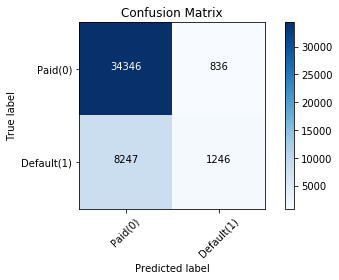

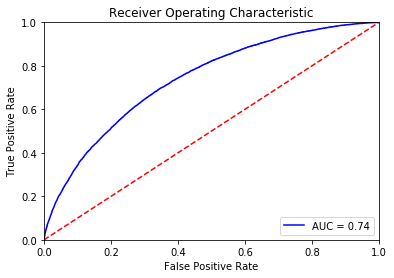

target,0.0,1.0
goals,,
A,6212,424
B,10743,1734
C,10411,3027
D,4768,2171
E,2077,1293
F,732,659
G,239,185


predict,0.0,1.0
goals,,
A,6635,1
B,12427,50
C,13093,345
D,6423,516
E,2776,594
F,986,405
G,253,171


No features to report for  bagging

Fit and Scoring  bagging+l2

Logging Results: bagging+l2
Scores:

    Auroc=0.721  rocauc=0.721  fbeta=0.403  recall=0.064  precision=0.601  Run Time(M)=0.000

    Best Score=0.000
    Best Params={'max_features': 0.75, 'max_samples': 0.75, 'n_estimators': 100}
    Goals= AUROC of 0.721 beats 0.700,  Precision of 0.601 beats 0.386,  



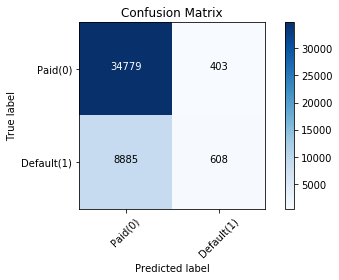

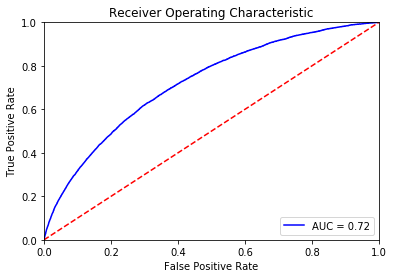

target,0.0,1.0
goals,,
A,6212,424
B,10743,1734
C,10411,3027
D,4768,2171
E,2077,1293
F,732,659
G,239,185


predict,0.0,1.0
goals,,
A,6636.0,0.0
B,12465.0,12.0
C,13318.0,120.0
D,6719.0,220.0
E,3062.0,308.0
F,1145.0,246.0
G,319.0,105.0


No features to report for  bagging+l2

Fit and Scoring  bagging+gbc

Logging Results: bagging+gbc
Scores:

    Auroc=0.734  rocauc=0.734  fbeta=0.434  recall=0.070  precision=0.644  Run Time(M)=0.000

    Best Score=0.000
    Best Params={'max_features': 0.75, 'max_samples': 0.75, 'n_estimators': 100}
    Goals= AUROC of 0.734 beats 0.700,  Precision of 0.644 beats 0.386,  



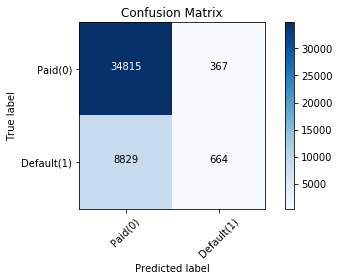

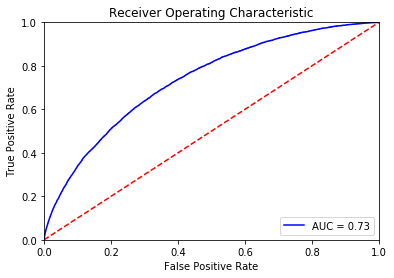

target,0.0,1.0
goals,,
A,6212,424
B,10743,1734
C,10411,3027
D,4768,2171
E,2077,1293
F,732,659
G,239,185


predict,0.0,1.0
goals,,
A,6636.0,0.0
B,12451.0,26.0
C,13298.0,140.0
D,6703.0,236.0
E,3077.0,293.0
F,1168.0,223.0
G,311.0,113.0


No features to report for  bagging+gbc

Fit and Scoring  l2

Logging Results: l2
Scores:

    Auroc=0.723  rocauc=0.723  fbeta=0.460  recall=0.110  precision=0.576  Run Time(M)=0.000

    Best Score=0.000
    Best Params={'C': 0.1, 'max_iter': 25, 'solver': 'sag'}
    Goals= AUROC of 0.723 beats 0.700,  Precision of 0.576 beats 0.386,  fbeta of 0.460 beats 0.440,  



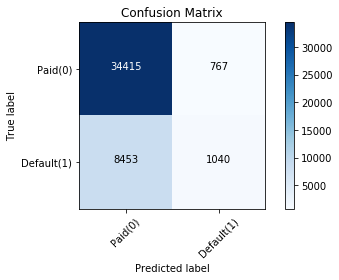

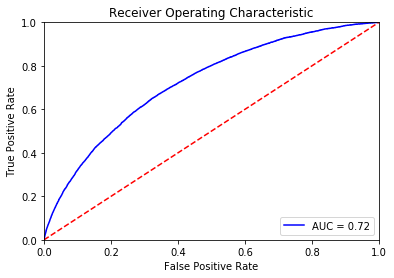

target,0.0,1.0
goals,,
A,6212,424
B,10743,1734
C,10411,3027
D,4768,2171
E,2077,1293
F,732,659
G,239,185


predict,0.0,1.0
goals,,
A,6635,1
B,12438,39
C,13178,260
D,6493,446
E,2850,520
F,1008,383
G,266,158


No Feature Importance Using Estimated coefficients


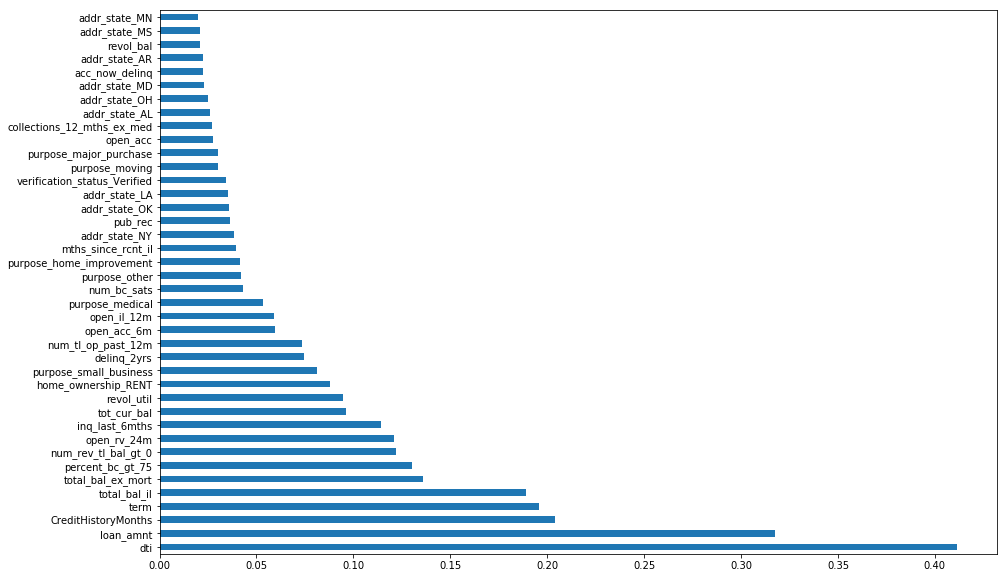


Fit and Scoring  l1

Logging Results: l1
Scores:

    Auroc=0.723  rocauc=0.723  fbeta=0.460  recall=0.109  precision=0.577  Run Time(M)=0.000

    Best Score=0.000
    Best Params={'C': 0.1, 'max_iter': 25, 'solver': 'liblinear'}
    Goals= AUROC of 0.723 beats 0.700,  Precision of 0.577 beats 0.386,  fbeta of 0.460 beats 0.440,  



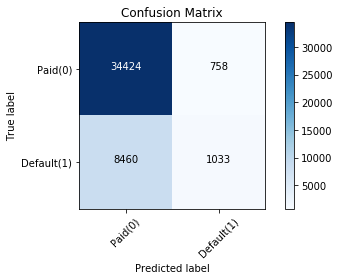

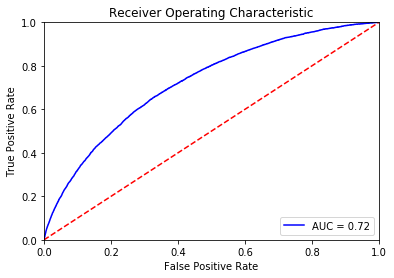

target,0.0,1.0
goals,,
A,6212,424
B,10743,1734
C,10411,3027
D,4768,2171
E,2077,1293
F,732,659
G,239,185


predict,0.0,1.0
goals,,
A,6635,1
B,12439,38
C,13182,256
D,6501,438
E,2852,518
F,1009,382
G,266,158


No Feature Importance Using Estimated coefficients


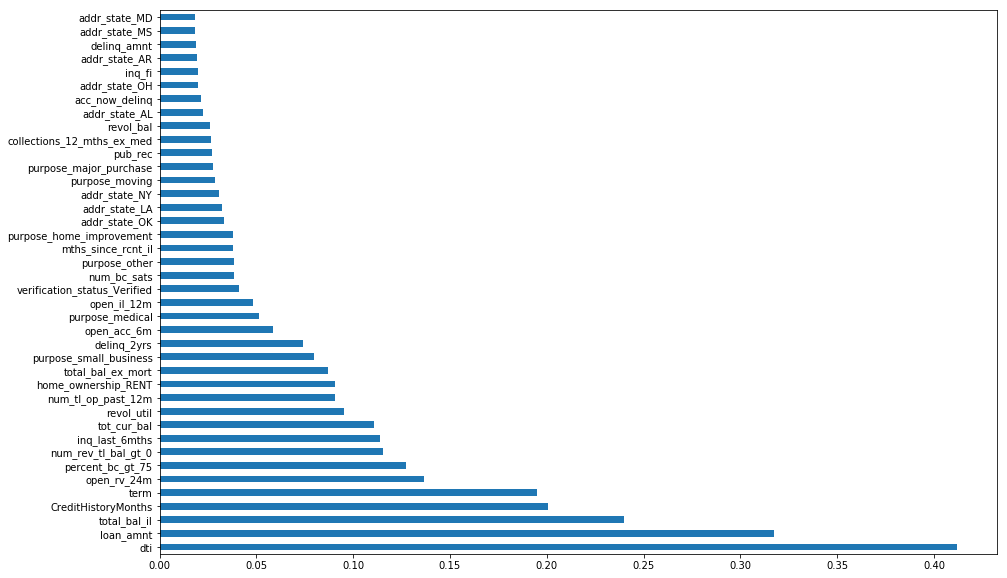

In [ ]:
runStackingModel(1, runSetup, stackingParams)
